# Task 3: Customer Segmentation / Clustering

Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

**Step 1: Loading the Datasets**


In [2]:
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

**Step 2: Data Preparation**

Converting date columns to datetime format


In [3]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

Merging customers and transaction data


In [4]:
merged_data = transactions.merge(customers, on='CustomerID', how='left')

Creating derived features for clustering


In [5]:
customer_features = merged_data.groupby('CustomerID').agg(
    total_spend=('TotalValue', 'sum'),
    avg_transaction_value=('TotalValue', 'mean'),
    total_transactions=('TransactionID', 'nunique'),
    region=('Region', 'first')
).reset_index()

Encoding categorical variables with one hot encoding


In [6]:
ohe = OneHotEncoder(sparse_output=False)
region_encoded = ohe.fit_transform(customer_features[['region']])
region_df = pd.DataFrame(region_encoded, columns=ohe.get_feature_names_out(['region']))

In [7]:
# Concatenate encoded region data
customer_features = pd.concat([customer_features, region_df], axis=1).drop(columns=['region'])

Normalize numerical features


In [8]:
scaler = StandardScaler()
# numerical_features = ['total_spend', 'avg_transaction_value', 'total_transactions']
# customer_features[numerical_features] = scaler.fit_transform(customer_features[numerical_features])
# customer_features = scaler.fit_transform(customer_features.drop("CustomerID", axis=1))
scaler = StandardScaler()
customer_features_scaled = scaler.fit_transform(customer_features.drop("CustomerID", axis=1))

# Convert scaled features back to DataFrame
customer_features_scaled = pd.DataFrame(customer_features_scaled, columns=customer_features.drop("CustomerID", axis=1).columns, index=customer_features.index)


**Step 3: Clustering**

Calculating DB index and Silhouette Score to get the optimal value of clusters

In [21]:
db_scores = []
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    customer_features['Cluster'] = kmeans.fit_predict(customer_features_scaled)

    # Calculate DB Index and silhouette score
    db_index = davies_bouldin_score(customer_features.drop(columns=['CustomerID', 'Cluster']), customer_features['Cluster'])
    silhouette_avg = silhouette_score(customer_features.drop(columns=['CustomerID', 'Cluster']), customer_features['Cluster'])

    db_scores.append(db_index)
    silhouette_scores.append(silhouette_avg)

    print(f"Clusters: {k}, DB Index: {db_index:.4f}, Silhouette Score: {silhouette_avg:.4f}")

Clusters: 2, DB Index: 0.6343, Silhouette Score: 0.5081
Clusters: 3, DB Index: 2.1101, Silhouette Score: 0.0889
Clusters: 4, DB Index: 9.2705, Silhouette Score: -0.1554
Clusters: 5, DB Index: 10.5427, Silhouette Score: -0.2068
Clusters: 6, DB Index: 4.6237, Silhouette Score: -0.2314
Clusters: 7, DB Index: 3.0761, Silhouette Score: -0.2194
Clusters: 8, DB Index: 7.2236, Silhouette Score: -0.1956
Clusters: 9, DB Index: 9.4381, Silhouette Score: -0.1514
Clusters: 10, DB Index: 9.5718, Silhouette Score: -0.1636


Plotting the elbow curve for silhouette scores


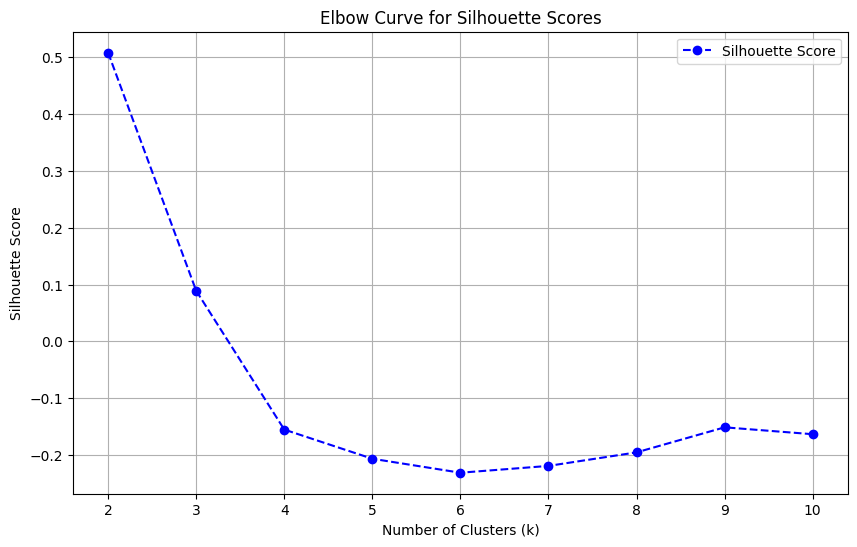

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--', color='b', label='Silhouette Score')
plt.title('Elbow Curve for Silhouette Scores')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.legend()
plt.grid()
plt.show()


In [19]:
# Step 4: Select Optimal Number of Clusters
optimal_k = k_values[np.argmin(db_scores)]
print(f"\nOptimal Number of Clusters: {optimal_k}")



Optimal Number of Clusters: 2


Fitting KMeans with Optimal Clusters


In [11]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(customer_features.drop(columns=['CustomerID']))

**Step 5: Visualization**

Reducing Dimensions for 2D Plot


In [12]:
pca = PCA(n_components=2)
customer_features['PCA1'], customer_features['PCA2'] = zip(*pca.fit_transform(customer_features.drop(columns=['CustomerID', 'Cluster'])))

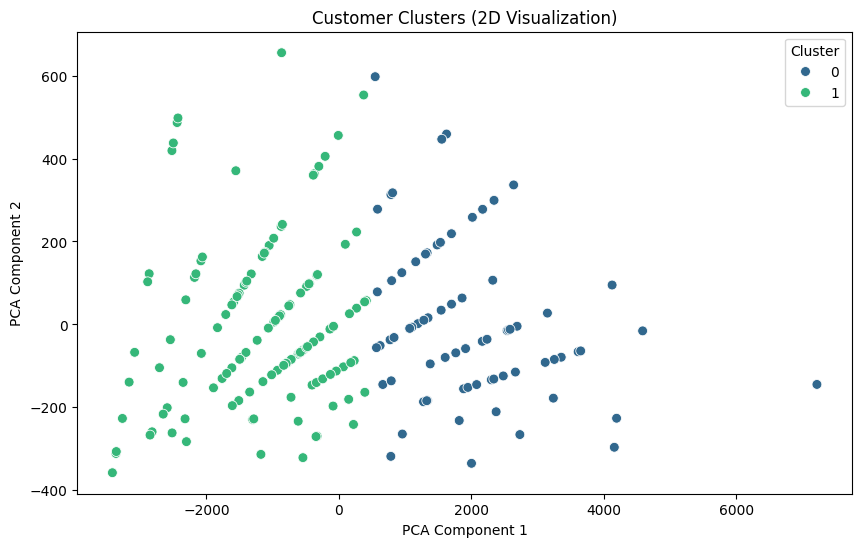

In [13]:
# Scatter Plot of Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', palette='viridis', data=customer_features, s=50
)
plt.title('Customer Clusters (2D Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

**Step 6: Export Clustering Results**


In [14]:
customer_features[['CustomerID', 'Cluster']].to_csv('Customer_Clusters.csv', index=False)

Step 7: Reporting Metrics


In [15]:
print(f"Optimal Number of Clusters: {optimal_k}")
print(f"DB Index for Optimal Clustering: {min(db_scores):.4f}")


Optimal Number of Clusters: 2
DB Index for Optimal Clustering: 0.6343
